In [1]:
from  isotools import Transcriptome
import isotools
print (f'This is isotools version {isotools.__version__}')

import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import logging
import pathlib

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


This is isotools version 0.3.3rc8


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/03_explorative/tables'
plot_path=f'{out_path}/03_explorative/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


## Load isoseq data

In [4]:

isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse.pkl


In [5]:
# define group and sample colors

groups={k:v for k,v in isoseq.groups().items() if k[:3] in ['CLL', 'MDS']}

group_dict={sa:gn for gn,sa_list in isoseq.groups().items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq.groups()[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq.groups()[gr]]
groups['B-cell']=isoseq.groups()['B-cell']
#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in isoseq.samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in isoseq.samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


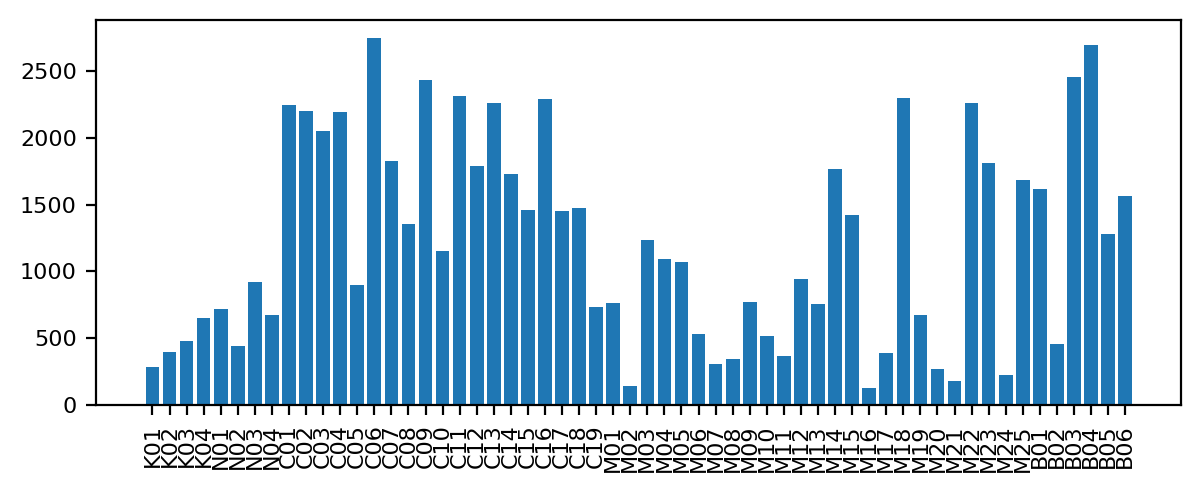

In [6]:
plt.rcParams["figure.figsize"] = (7,2.5)
RBM39=pd.Series(isoseq['RBM39'].coverage.sum(1)/isoseq.sample_table.nonchimeric_reads.values*1e6, index=isoseq.samples)
plt.bar(RBM39.index,RBM39.values)
_=plt.xticks(rotation=90)

Gene ZNF107 chr7:64666082-64711582(+), 6 reference transcripts, 329 expressed transcripts


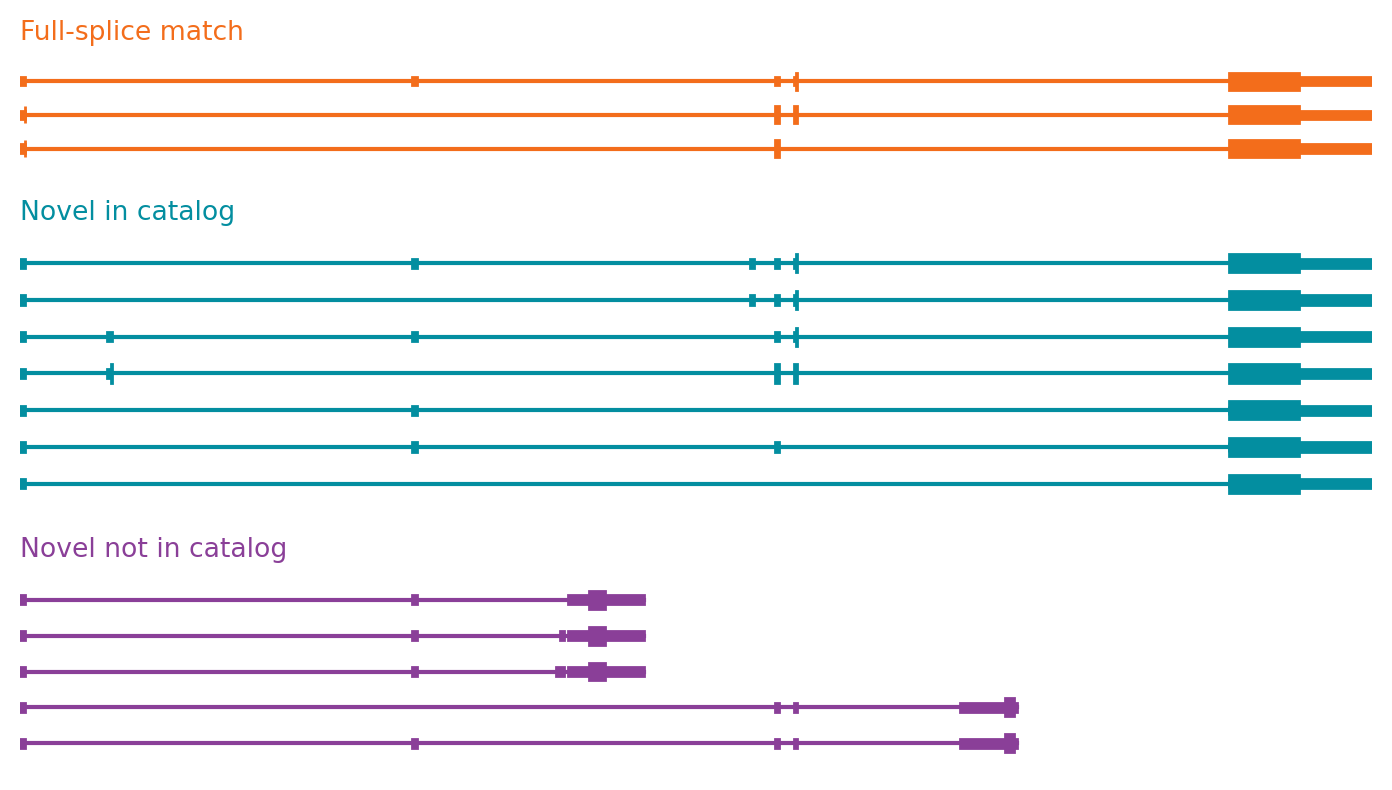

In [40]:

goi='ZNF107'
g=isoseq[goi]
print(g)
tr_cat={}
cat_name=['Full-splice match','Incomplete splice match','Novel in catalog','Novel not in catalog','Novel']
cat_colors=['#f36d1b','#70ad47','#038ea0','#8a3f98','#a5a5a5']
tr_sel=[(i,g.transcripts[i]) for i in g.filter_transcripts('SUBSTANTIAL and not (NOVEL_TRANSCRIPT and UNSPLICED)', min_coverage=5)]
for i,tr in tr_sel:
    tr_cat.setdefault(tr['annotation'][0],[]).append(i)
tr_cat
tr_range=[min(tr['exons'][0][0] for i,tr in tr_sel),max(tr['exons'][-1][1] for i,tr in tr_sel) ]
fig, axs = plt.subplots( len(tr_cat), sharex=True, height_ratios=[len(tr_cat[i]) for i in sorted(tr_cat)], figsize=(7,4), layout='tight')
for i,ax in zip(sorted(tr_cat), axs):
    cat=cat_name[i]
    g.gene_track(reference=False, select_transcripts=tr_cat[i], ax=ax, title='', label_exon_numbers=False, label_transcripts=False, x_range=tr_range, color=cat_colors[i])
    ax.set_title(cat, loc='left', color=cat_colors[i])
    ax.invert_yaxis()
ax.set_xticks([])   
fig.savefig(f'{plot_path}/{project}_{date}_all_transcripts_{goi}.pdf', bbox_inches='tight')


## PCA plots

In [7]:
#as_events=isoseq.alternative_splicing_events(progress_bar=True)
#as_events.to_csv(f'{table_path}/{project}_{date}_as_events.csv', index=False)
as_events=pd.read_csv(f'{table_path}/{project}_{date}_as_events.csv')


In [ ]:
###### diff_cmp='all'
plt.rcParams["figure.figsize"] = (6,3)

total_cov=as_events[[c for c in as_events.columns if 'total_cov' in c]].sum(1)
total_psi=as_events[[c for c in as_events.columns if 'in_cov' in c]].sum(1)/total_cov
# thresholds where: 100 reads, minor alternative >10%

#sel=as_events[diff_cmp].padj<.1
#tmp=res[diff_cmp].loc[sig, ['splice_type', 'novel']]
n_type=pd.DataFrame({'novel':as_events.splice_type[as_events.novel].value_counts(), 'known':as_events.splice_type[~as_events.novel].value_counts()}).fillna(0)
#(n_type/n_type.values.sum()*100).plot.bar(stacked=True)
event_types=['ES','IR','ME','5AS','3AS']
n_type.loc[event_types].plot.bar(stacked=True)
plt.savefig(f'{plot_path}/{project}_{date}_altsplice_type_bar.pdf', bbox_inches='tight')

total=n_type.loc[event_types].sum().sum()
print(n_type.loc[event_types].sum()/total)
n_type

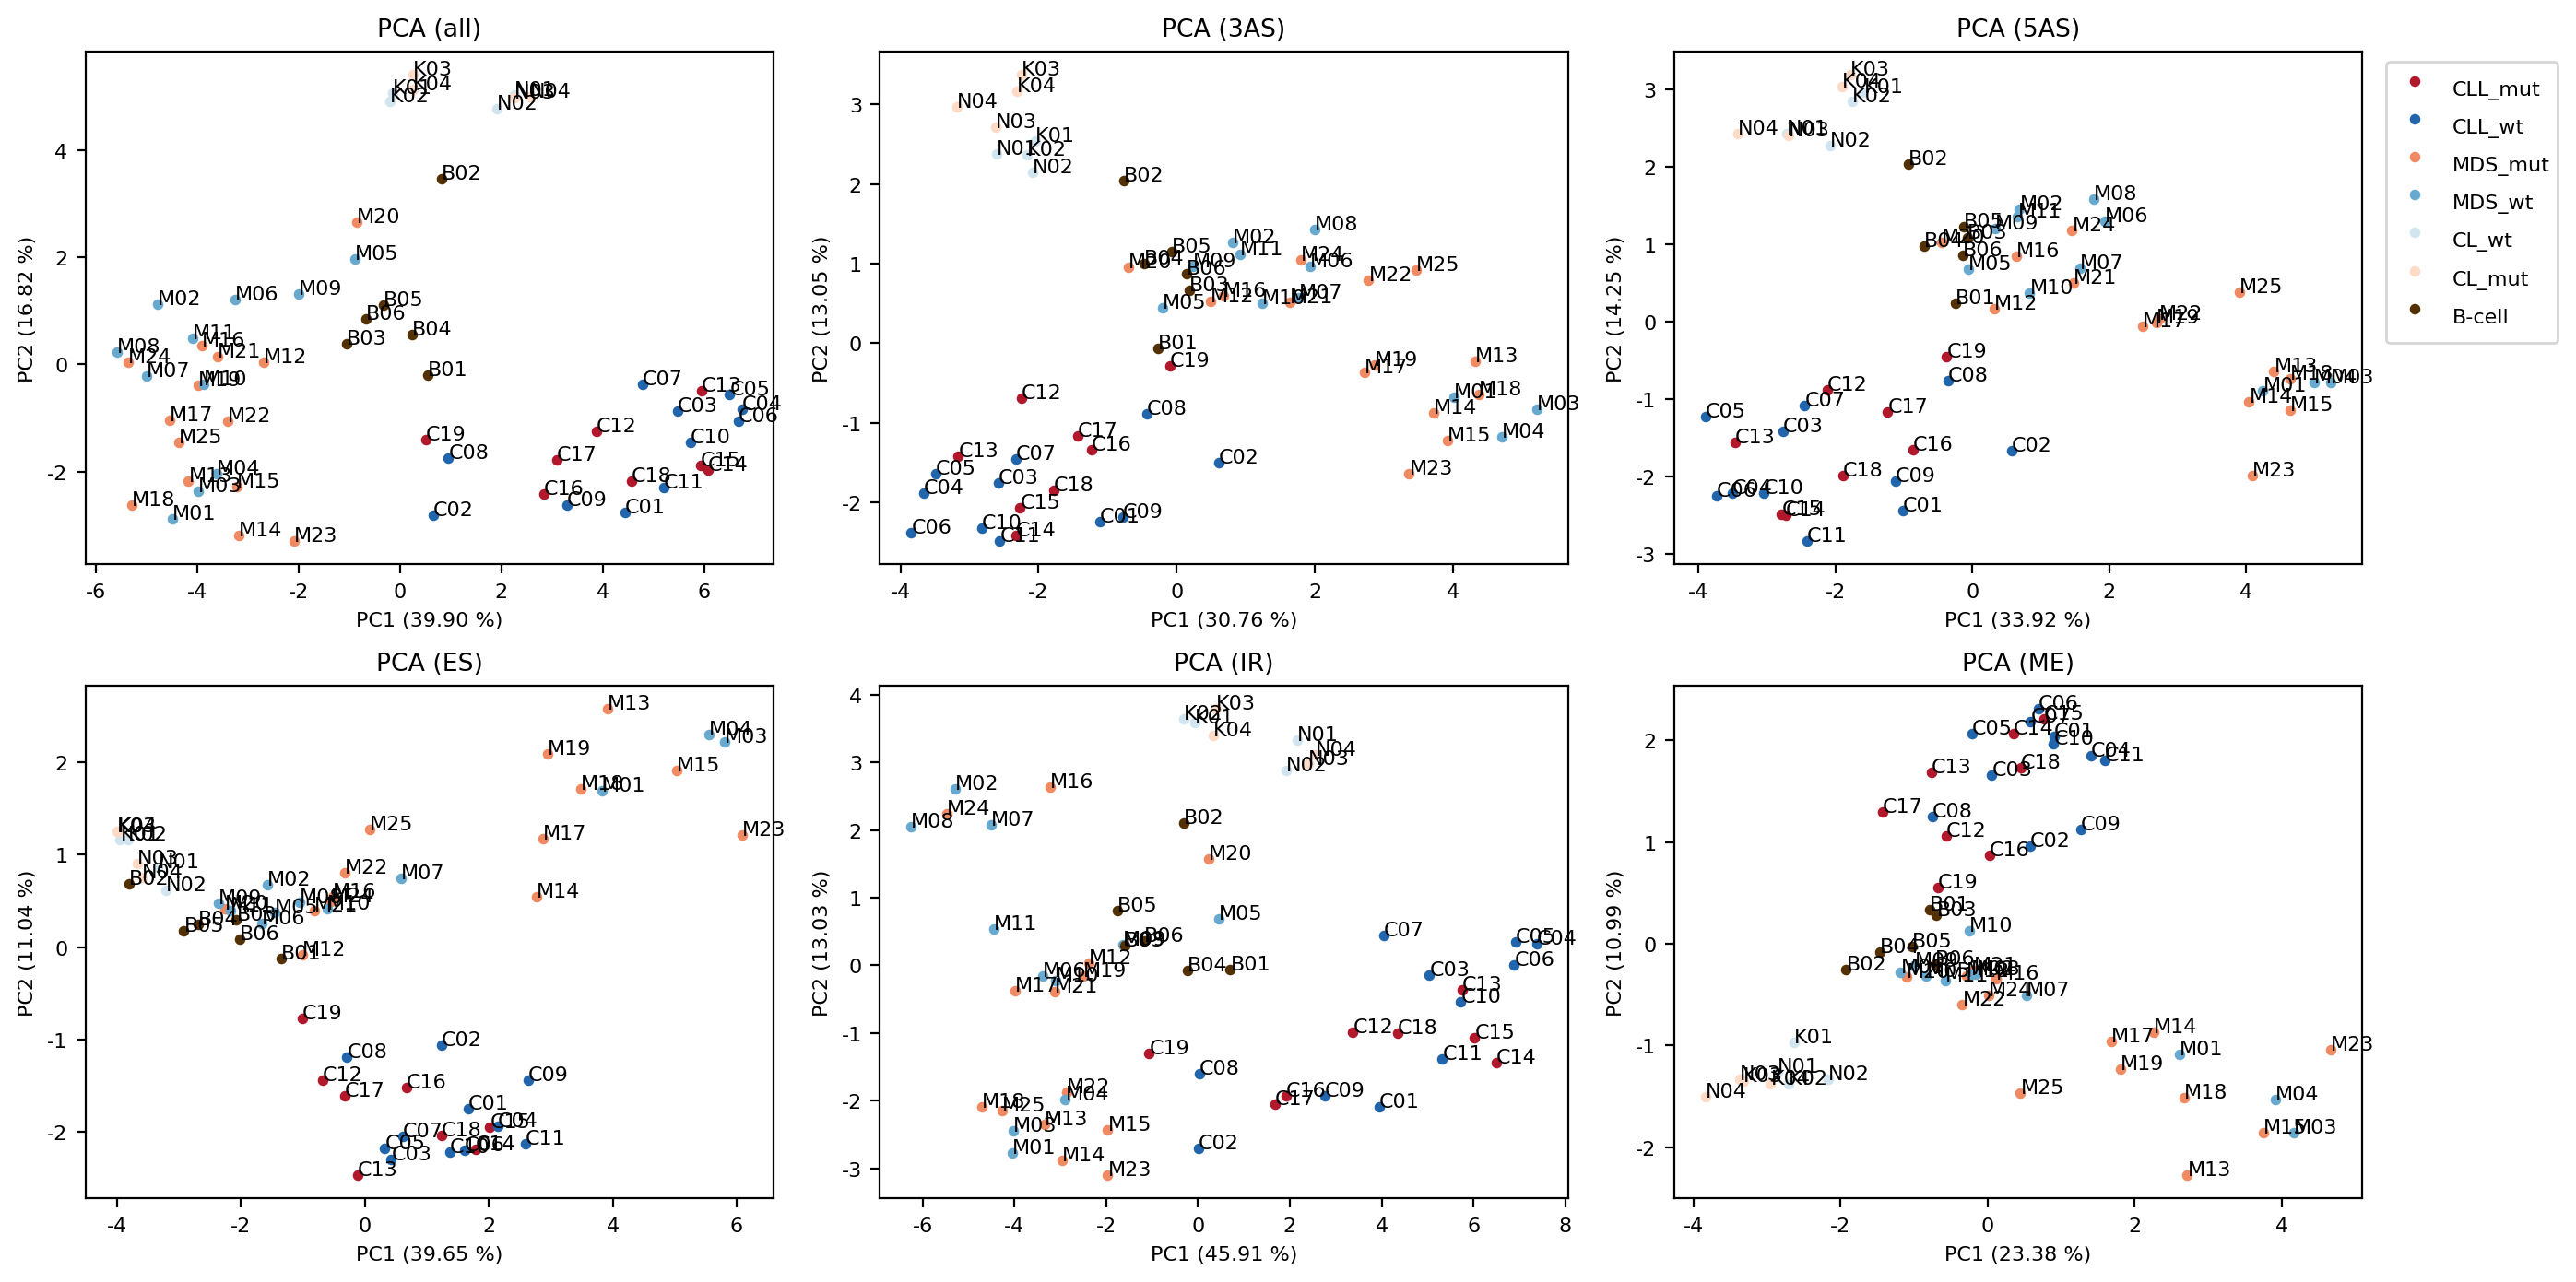

In [19]:
from isotools.plots import plot_embedding
#plt.rcParams["figure.figsize"] = (7,3.5)
plt.rcParams["figure.figsize"] = (14,7)
components={}
pca={}
p={}
f,axs=plt.subplots(2,3)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME']):
    p_i,comp_i, pca_i=plot_embedding(as_events, ax=ax, groups=groups, splice_types=t, labels=True, colors=group_colors, pt_size=10, plot_components=[1,2])
    components[t]=comp_i
    pca[t]=pca_i
    p[t]=p_i

axs[0,2].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f'{plot_path}/{project}_{date}_PCA_large.pdf') 


INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04


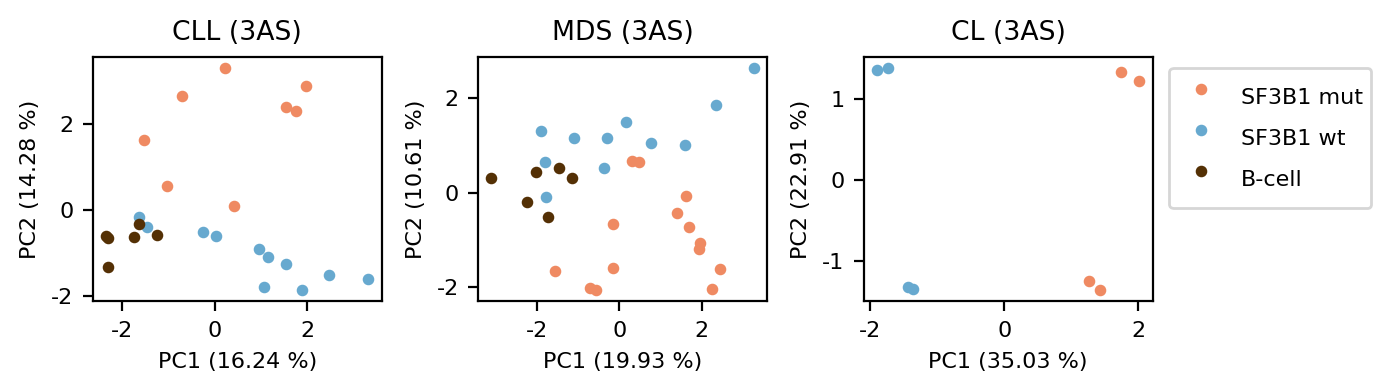

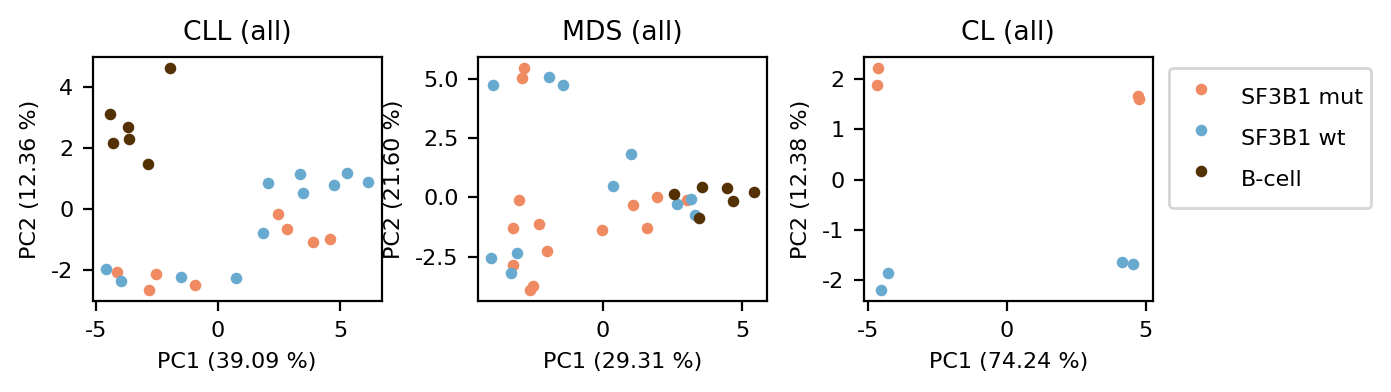

In [20]:
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (7,2)
#plt.rcParams["figure.figsize"] = (14,4)
for t in ['3AS', 'all']:
    components={}
    pca={}
    p={}
    f,axs=plt.subplots(1,3)
    handles={}
    for ax,gr in zip(axs,[groups_CLL,groups_MDS,groups_CL]):
        gr_name=list(gr.keys())[1].split('_')[0]
        gr_rename={grn.replace(gr_name, 'all'):g for grn,g in gr.items()}
        p_i,comp_i, pca_i=plot_embedding(as_events, ax=ax, labels=False, groups=gr_rename, splice_types=t, colors=group_colors, pt_size=10)
        ax.set_title(f'{gr_name} ({t})')
        components[t]=comp_i
        pca[t]=pca_i
        p[t]=p_i
        h_i, l_i = ax.get_legend_handles_labels()
        handles.update(dict(zip(l_i, h_i)))
    #f.legend([handles[l] for l in groups], list(groups), fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1, 1), loc='upper left')
    ax.legend([handles[l] for l in handles], [h.replace('all_', 'SF3B1 ') for h in list(handles)],fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
    f.tight_layout()
    f.savefig(f'{plot_path}/{project}_{date}_{t}_PCA_large.pdf', dpi=1200) 


INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04
INFO:restricting embedding on samples K01, K02, K03, K04, N01, N02, N03, N04


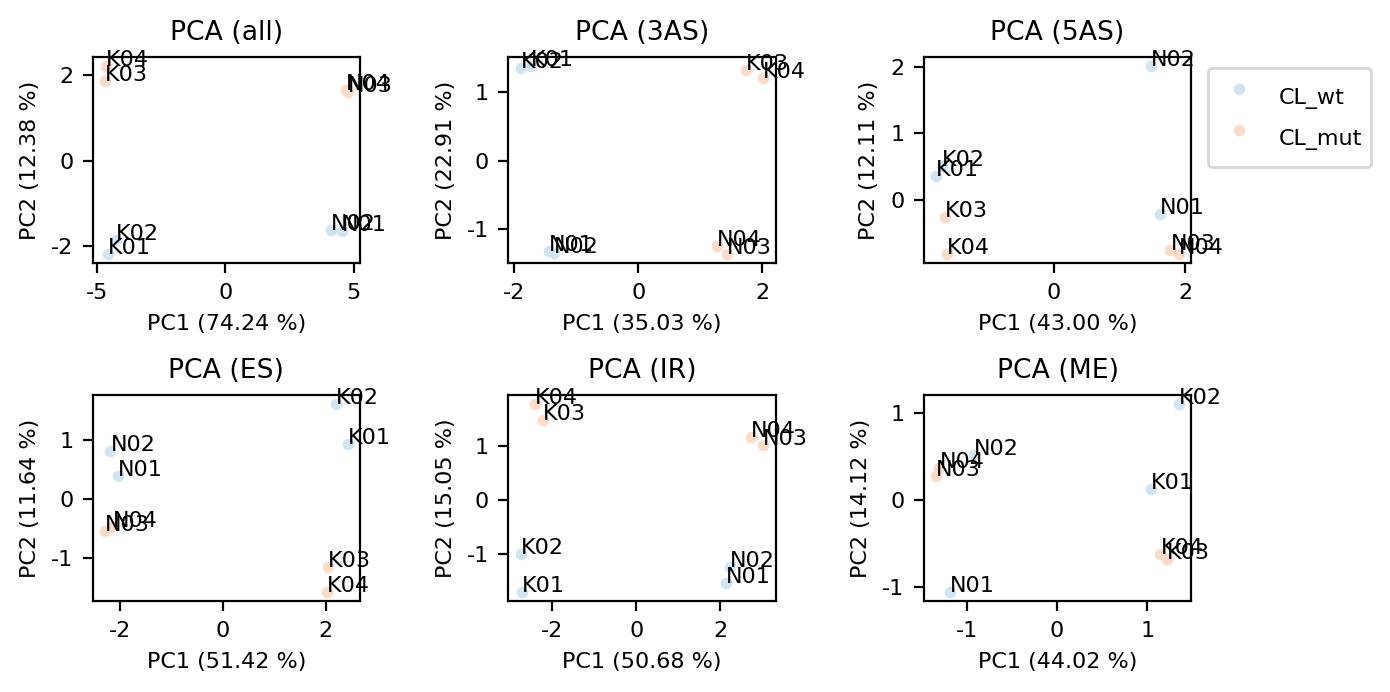

In [21]:
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (7,3.5)
components={}
pca={}
p={}
f,axs=plt.subplots(2,3)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME']):
    p_i,comp_i, pca_i=plot_embedding(as_events, ax=ax, labels=True, groups=groups_CL, splice_types=t, colors=group_colors, pt_size=10)
    components[t]=comp_i
    pca[t]=pca_i
    p[t]=p_i

axs[0,2].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f'{plot_path}/{project}_{date}_Celllines_PCA.pdf') 


INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples C01, C02, C03, C04, C05, C06, C07, C08, C09, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, B01, B02, B03, B04, B05, B06


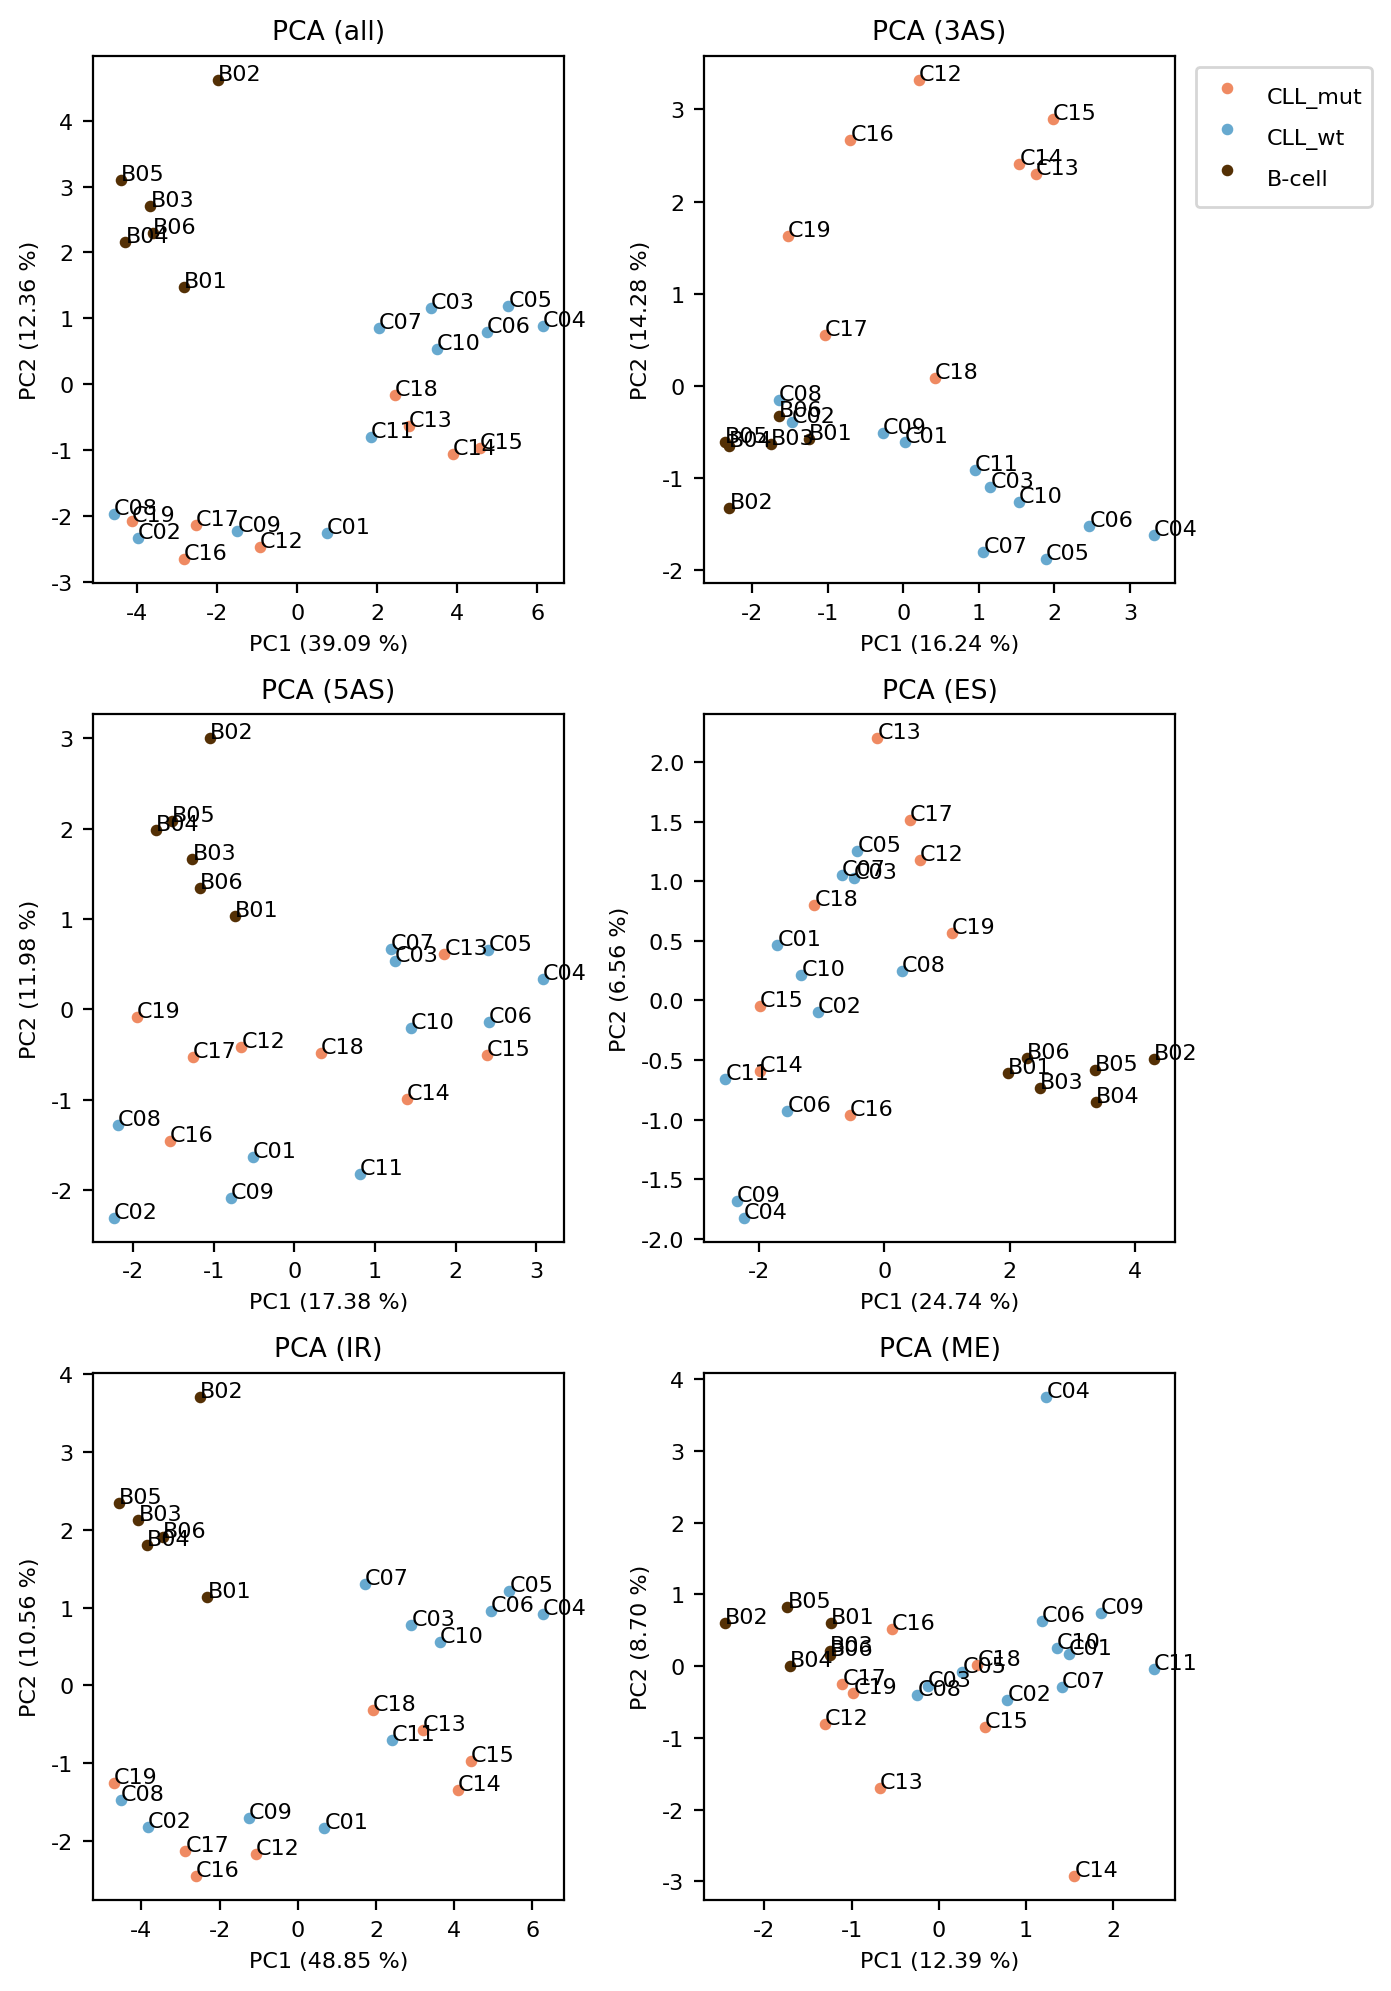

In [22]:
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (7,10)
components={}
pca={}
p={}
f,axs=plt.subplots(3,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME']):
    p_i,comp_i, pca_i=plot_embedding(as_events, ax=ax, labels=True, groups=groups_CLL, splice_types=t, colors=group_same_colors , pt_size=10)
    components[t]=comp_i
    pca[t]=pca_i
    p[t]=p_i

axs[0,1].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f'{plot_path}/{project}_{date}_CLL_PCA.pdf') 


INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M01, M02, M03, M04, M05, M06, M07, M08, M09, M10, M11, M12, M13, M14, M15, M16, M17, M18, M19, M20, M21, M22, M23, M24, M25, B01, B02, B03, B04, B05, B06
INFO:restricting embedding on samples M0

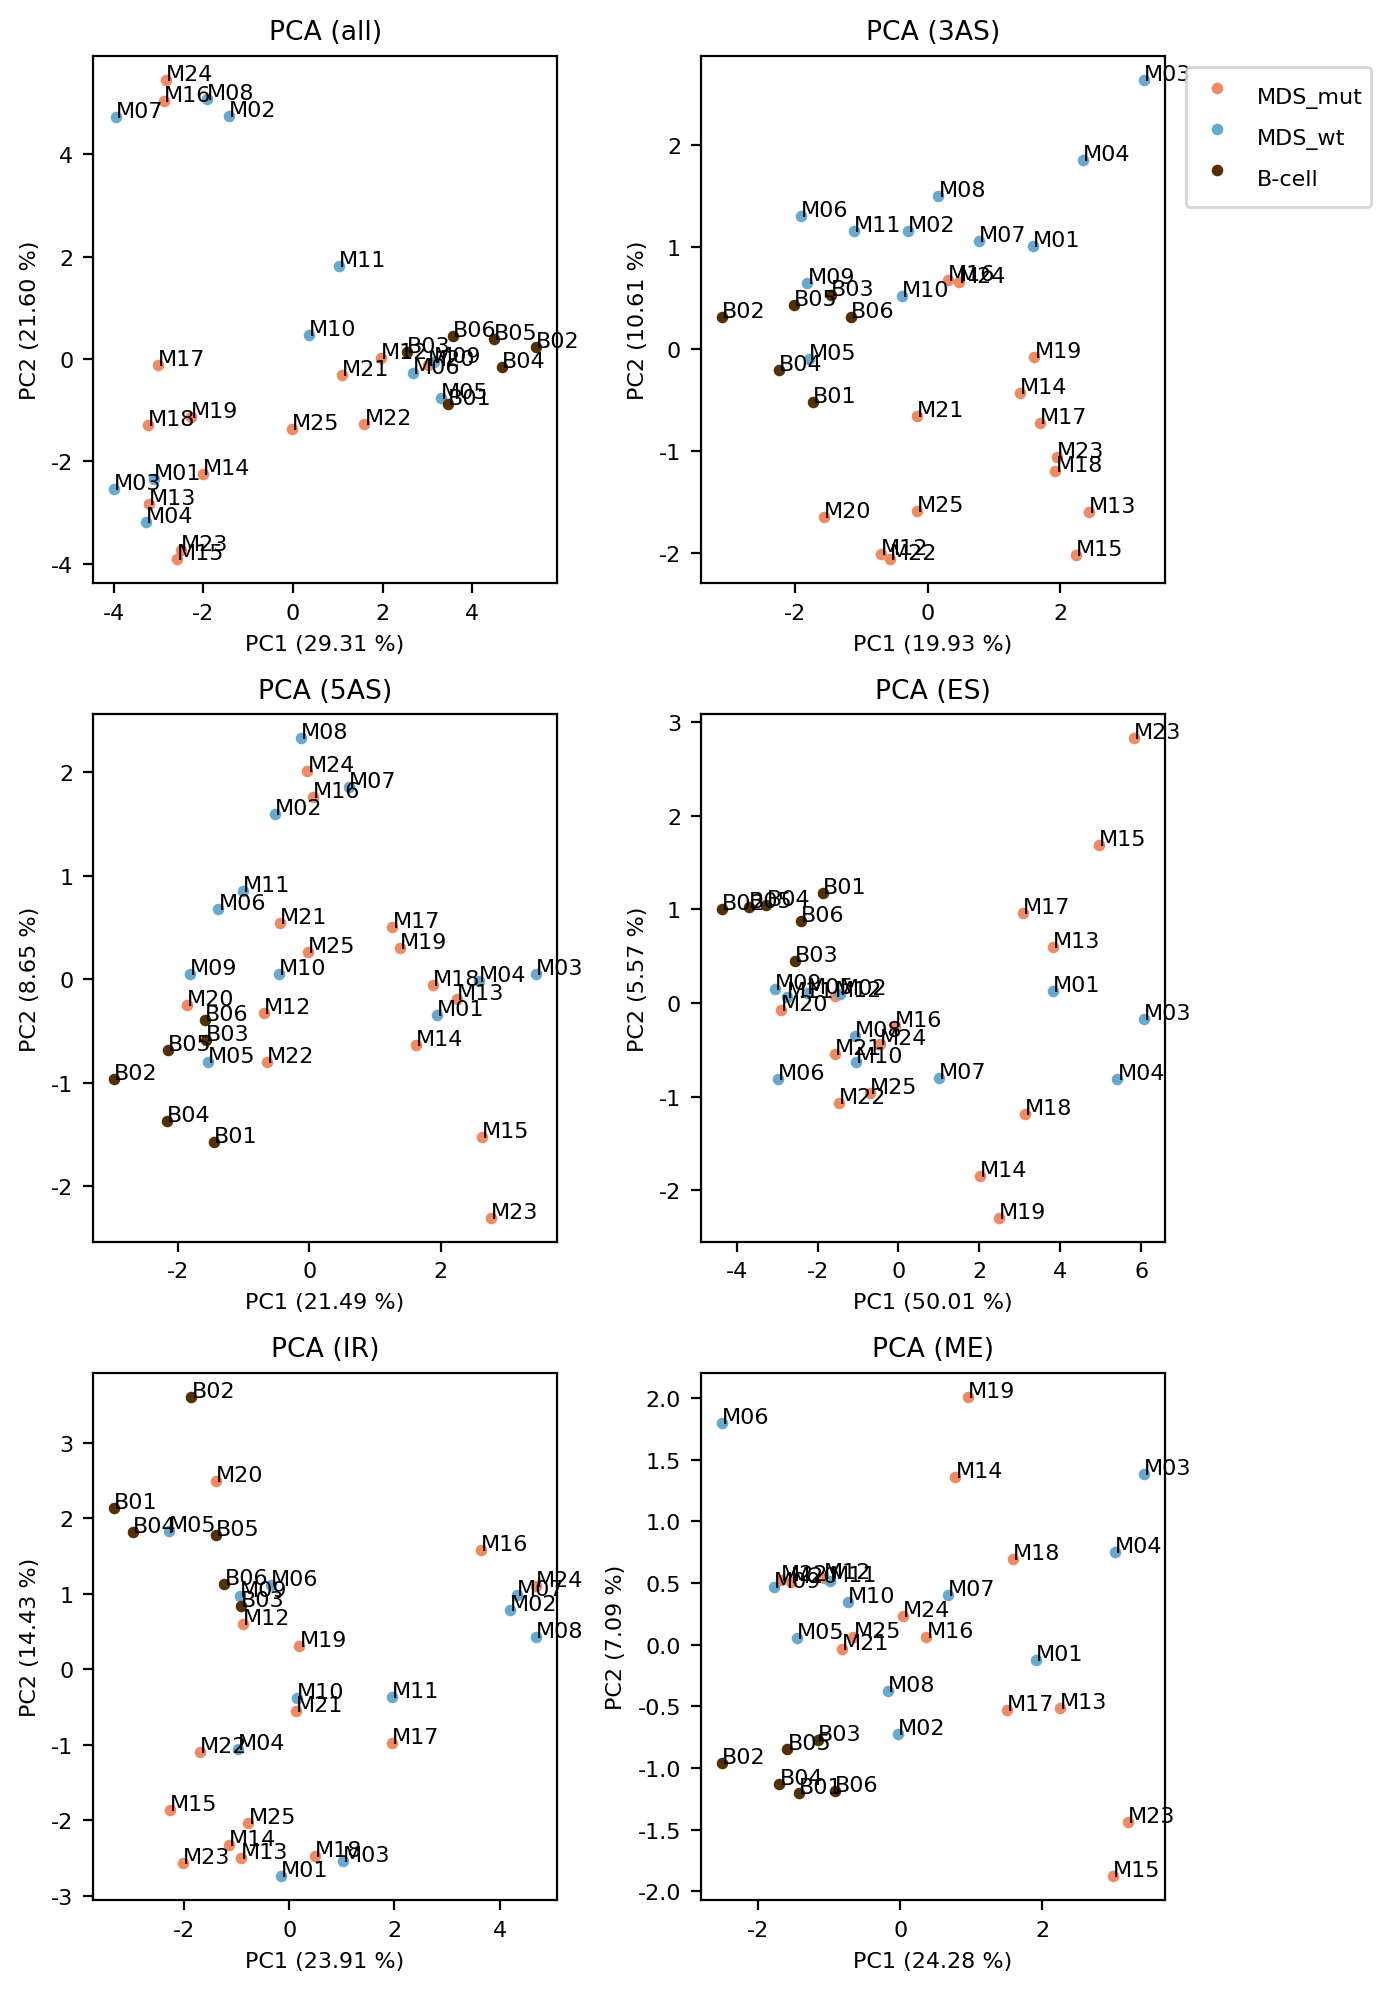

In [23]:
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (7,10)
components={}
pca={}
p={}
f,axs=plt.subplots(3,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME']):
    p_i,comp_i, pca_i=plot_embedding(as_events, ax=ax, labels=True, groups=groups_MDS, splice_types=t,  colors=group_colors, pt_size=10)
    components[t]=comp_i
    pca[t]=pca_i
    p[t]=p_i

axs[0,1].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f'{plot_path}/{project}_{date}_MDS_PCA.pdf') 


2023-02-09 10:36:42.865798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 10:36:43.300250: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


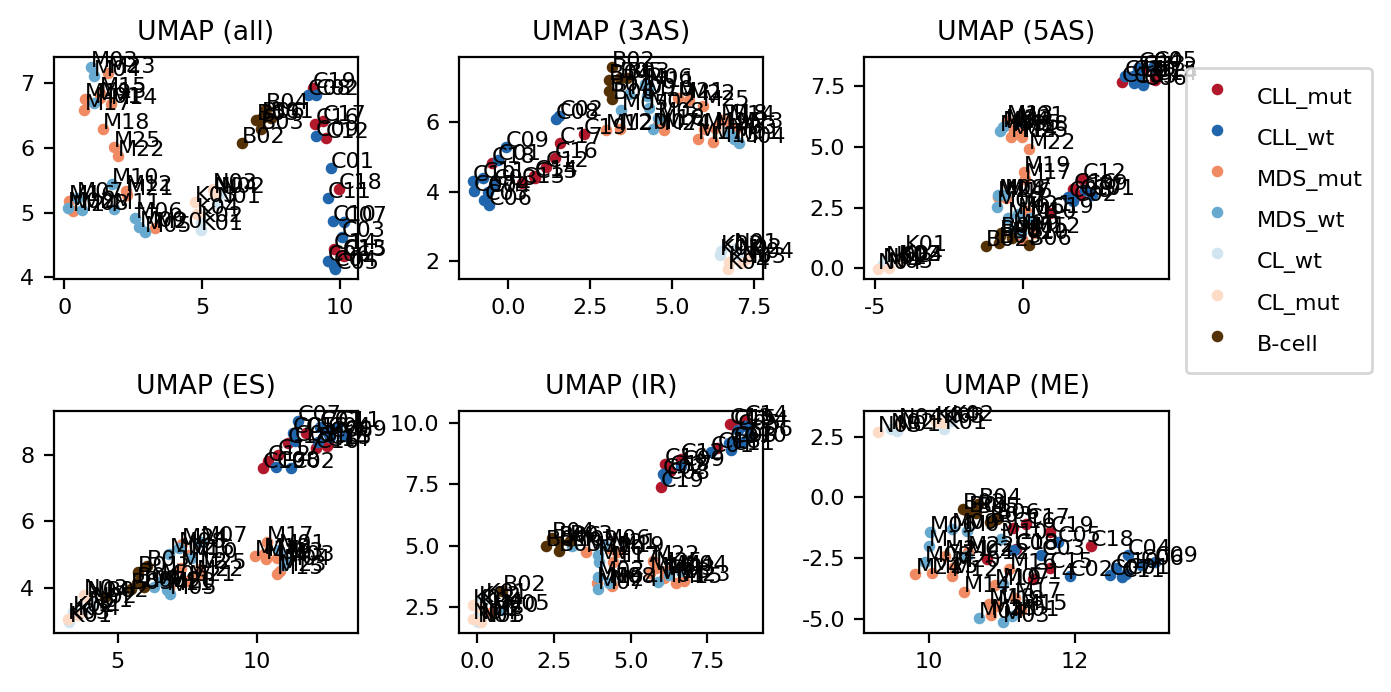

In [24]:
plt.rcParams["figure.figsize"] = (7,3.5)
f,axs=plt.subplots(2,3)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME']):
    p_i,comp_i, umap_i=plot_embedding(as_events, ax=ax,method="UMAP",n_neighbors=10, labels=True, groups=groups, splice_types=t, pt_size=10,  colors=group_colors)

axs[0,2].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.savefig(f'{plot_path}/{project}_{date}_UMAP.pdf') 


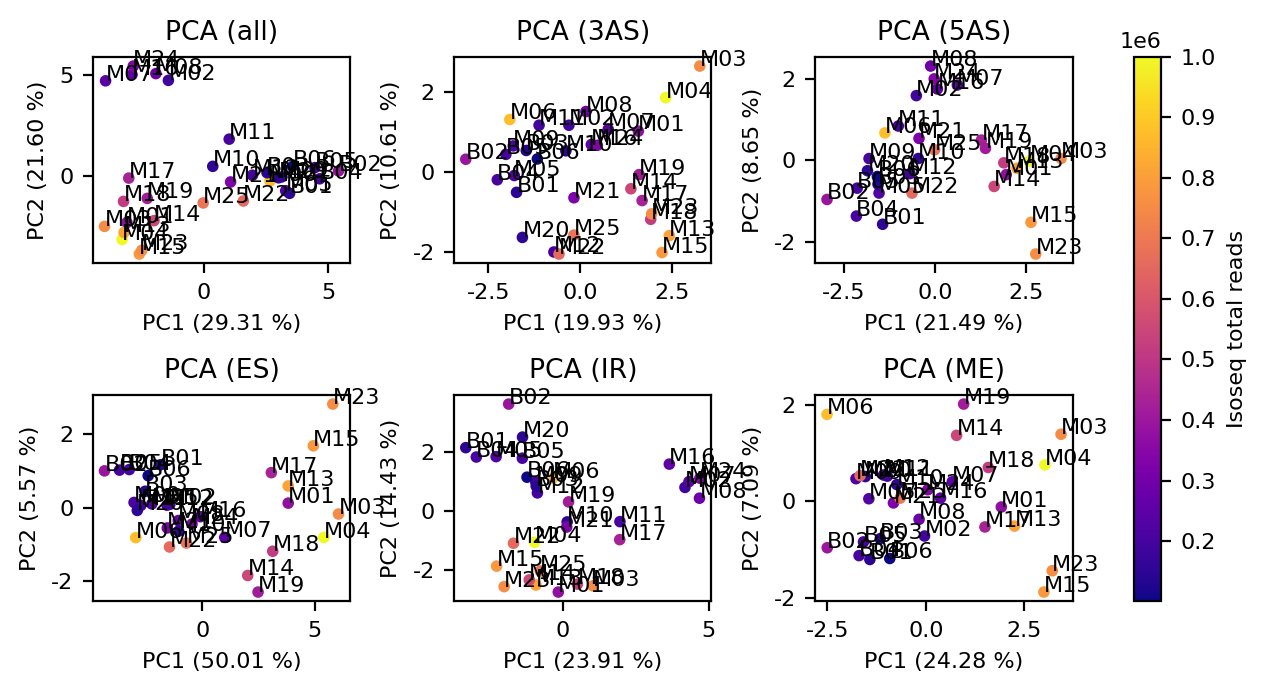

In [25]:
plt.rcParams["figure.figsize"] = (7,3.5)
cm = plt.get_cmap('plasma')
f,axs=plt.subplots(2,3)

for ax,t in zip(axs.flatten(),components):    
    cov=[c if c<1e6 else 1e6 for c in isoseq.sample_table.set_index('name').nonchimeric_reads[components[t].index]]

    im=ax.scatter(components[t][0],components[t][1],c=cov, cmap=cm, s=10)
    ax.set(title= f'PCA ({t})',
           xlabel =f'PC1 ({pca[t].explained_variance_ratio_[0]*100:.2f} %)', 
           ylabel =f'PC2 ({pca[t].explained_variance_ratio_[1]*100:.2f} %)')
    for idx,(x,y) in components[t].iterrows():
        ax.text(x,y,s=idx)
plt.tight_layout()
cbar=f.colorbar(im, ax=axs.flatten().tolist())
cbar.set_label('Isoseq total reads', rotation=90)

plt.savefig(f'{plot_path}/{project}_{date}_PCA_coverage.pdf') 


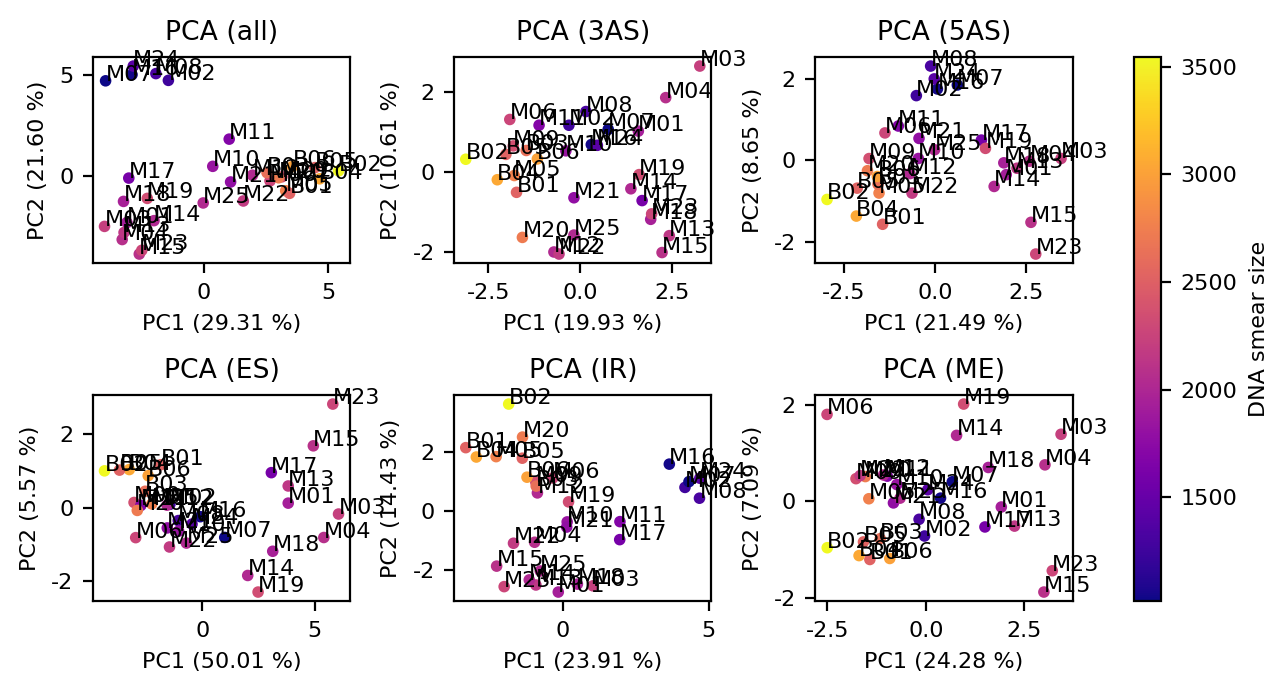

In [34]:
plt.rcParams["figure.figsize"] = (7,3.5)
cm = plt.get_cmap('plasma')
f,axs=plt.subplots(2,3)
for ax,t in zip(axs.flatten(),components):    
    smear=[s if np.isfinite(s) else 1500 for s in isoseq.sample_table.set_index('name').DNA_smear[components[t].index]]

    im=ax.scatter(components[t][0],components[t][1],c=smear, cmap=cm, s=10)
    ax.set(title= f'PCA ({t})',
           xlabel =f'PC1 ({pca[t].explained_variance_ratio_[0]*100:.2f} %)', 
           ylabel =f'PC2 ({pca[t].explained_variance_ratio_[1]*100:.2f} %)')
    for idx,(x,y) in components[t].iterrows():
        ax.text(x,y,s=idx)
        
plt.tight_layout()
cbar=f.colorbar(im, ax=axs.flatten().tolist())
cbar.set_label('DNA smear size', rotation=90)
plt.savefig(f'{plot_path}/{project}_{date}_PCA_DNA_smear.pdf') 


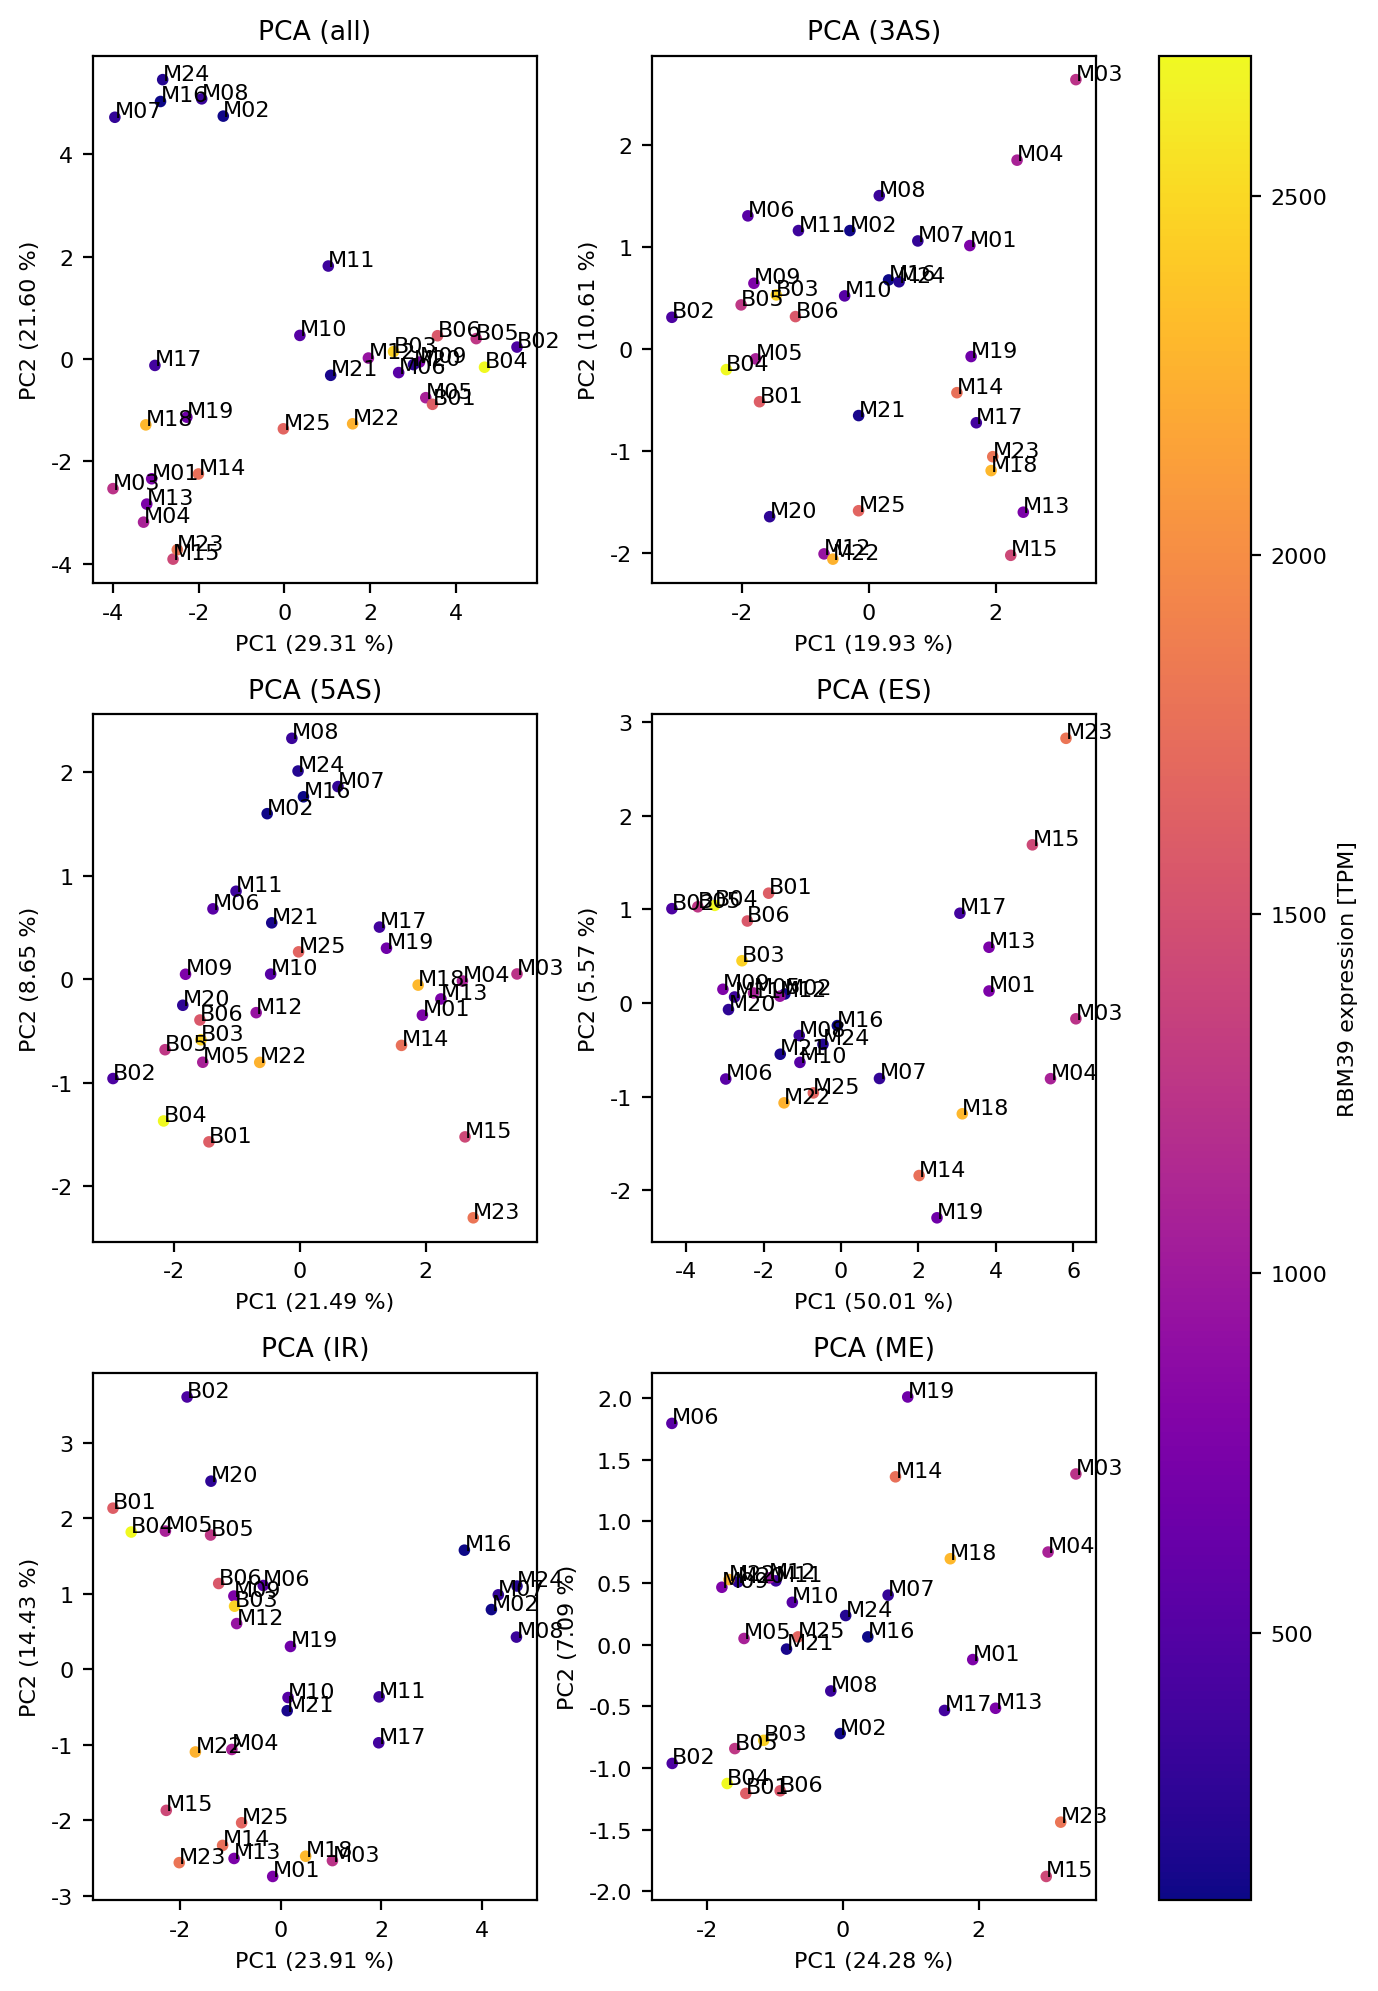

In [41]:

plt.rcParams["figure.figsize"] = (7,10)
cm = plt.get_cmap('plasma')
f,axs=plt.subplots(3,2)
for ax,t in zip(axs.flatten(),components):    
    #smear=[s if np.isfinite(s) else 1500 for s in isoseq.sample_table.set_index('name').DNA_smear[components[t].index]]

    im=ax.scatter(components[t][0],components[t][1],c=[RBM39[sa] for sa in components[t].index] , cmap=cm, s=10)
    ax.set(title= f'PCA ({t})',
           xlabel =f'PC1 ({pca[t].explained_variance_ratio_[0]*100:.2f} %)', 
           ylabel =f'PC2 ({pca[t].explained_variance_ratio_[1]*100:.2f} %)')
    for idx,(x,y) in components[t].iterrows():
        ax.text(x,y,s=idx)
        
plt.tight_layout()
cbar=f.colorbar(im, ax=axs.flatten().tolist())
cbar.set_label('RBM39 expression [TPM]', rotation=90)
plt.savefig(f'{plot_path}/{project}_{date}_PCA_RBM39.pdf') 


In [27]:
isoseq.sample_table

,name,file,group,nonchimeric_reads,chimeric_reads,internal_id,phenotype,genotype,platform,TSM_ID,sample_pool,DNA_smear,illumina_sample_id,SF3B1_mut,SF3B1_AF
0,K01,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_wt,694647,314,K562_wt_1,K562,wt,S2,D001,1-1,2828.0,MRS938,,
0,K02,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_wt,525087,540,K562_wt_2,K562,wt,S2,D002,1-1,2692.0,MRS940,,
0,K03,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_mut,874809,880,K562_mut_1,K562,mut,S2,D003,1-1,3036.0,MRS939,p.Lys700Glu,41.0
0,K04,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,K562_mut,795126,709,K562_mut_2,K562,mut,S2,D004,1-1,2940.0,MRS941,p.Lys700Glu,45.0
0,N01,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_wt,545784,151,Nalm6_wt_1,Nalm6,wt,S2,D005,1-2,3054.0,MRS942,,
0,N02,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_wt,355818,63,Nalm6_wt_2,Nalm6,wt,S2,D006,1-2,3119.0,MRS944,,
0,N03,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_mut,635575,640,Nalm6_mut_1,Nalm6,mut,S2,D007,1-2,3197.0,MRS943,p.His662Gln,28.0
0,N04,/project/42/pacbio/golong/05d-raw_align_mm2/D0...,Nalm6_mut,859604,154,Nalm6_mut_2,Nalm6,mut,S2,D008,1-2,3292.0,MRS945,p.His662Gln,29.0
0,C01,/project/42/pacbio/golong/05d-raw_align_mm2/25...,CLL_wt,676483,954,CLL171,CLL,wt,S2,25-10,2-1,2753.0,MRS621,,
0,C02,/project/42/pacbio/golong/05d-raw_align_mm2/25...,CLL_wt,460625,306,CLL113,CLL,wt,S2,25-11,2-1,2191.0,MRS611,,
